In [ ]:
###invasion maps

In [1]:
#import necessary packages
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
np.__version__
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text 
#from mpl_toolkits.basemap import Basemap as Basemap ##issues getting this onto my computer

In [2]:
#read in invasion metric .csv and sort
metric = pd.read_csv("full_response.csv")
metric.sort_values('rel_invasive_richness',ascending=False)
#read in location data for NEON sites and sort
meta = pd.read_csv("NEON_Field_Site_Metadata_20220412.csv")
location_data = meta[["field_site_id", "field_latitude", "field_longitude"]]
location_data = location_data.rename(columns={"field_site_id":"siteID"})
#combine invasion and location tables and condense to RIR function 
combo = location_data.merge(metric, how = 'inner')
RIR = combo[["siteID", "field_latitude", "field_longitude", "rel_invasive_richness", "rel_inv_abund"]]
combo.head()

,siteID,field_latitude,field_longitude,Unnamed: 0,rel_invasive_richness,rel_inv_abund,shannon.x,totalAbund,siteRichness
0,ARIK,39.758206,-102.447150,1,0.100000,24.205225,2.302585,3177,10
1,BIGC,37.059719,-119.257550,2,0.500000,98.732171,0.693147,1262,2
2,BLDE,44.950110,-110.587150,3,1.000000,100.000000,0.000000,728,1
3,BLUE,34.444218,-96.624201,4,0.038462,0.854701,3.258097,1521,26
4,CARI,65.153224,-147.503970,5,0.500000,46.808511,0.693147,47,2


<AxesSubplot:>

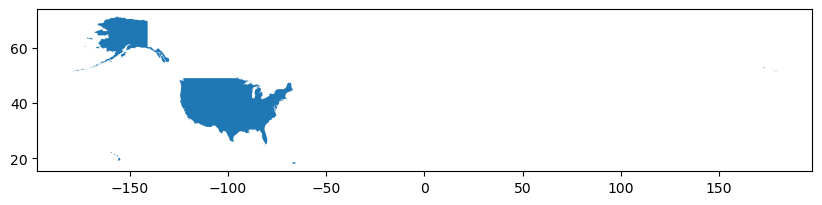

In [3]:
##map downloaded from census.gov, 2018 US nation 20m
##makes plain map of the U.S
US_map = gpd.read_file("cb_2018_us_nation_20m.shp")
#change CR from NAD83 to WGS84
US_map = US_map.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize = (10, 100))
US_map.plot(ax=ax)

In [5]:
#renaming some things 
df = RIR
crs = {'init':'epsg:4326'} #sets data CRS to WGS84 (what NEON uses)
geometry = [Point(xy) for xy in zip(RIR["field_longitude"], RIR["field_latitude"])] #makes lat and long a geometry point
#geometry[:3]
len(geometry) #28 points yay!

28

In [6]:
#create a geo dataframe with lat and long points and invasion data
geo_df = gpd.GeoDataFrame(RIR, 
                          crs = crs, 
                          geometry = geometry)
#make sure response variable is a numeric
geo_df['rel_invasive_richness'] = pd.to_numeric(geo_df['rel_invasive_richness'])
geo_df['rel_inv_abund'] = pd.to_numeric(geo_df['rel_inv_abund'])
geo_df.head()

C:\Anaconda_MACS401\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,siteID,field_latitude,field_longitude,rel_invasive_richness,rel_inv_abund,geometry
0,ARIK,39.758206,-102.447150,0.100000,24.205225,POINT (-102.44715 39.75821)
1,BIGC,37.059719,-119.257550,0.500000,98.732171,POINT (-119.25755 37.05972)
2,BLDE,44.950110,-110.587150,1.000000,100.000000,POINT (-110.58715 44.95011)
3,BLUE,34.444218,-96.624201,0.038462,0.854701,POINT (-96.62420 34.44422)
4,CARI,65.153224,-147.503970,0.500000,46.808511,POINT (-147.50397 65.15322)


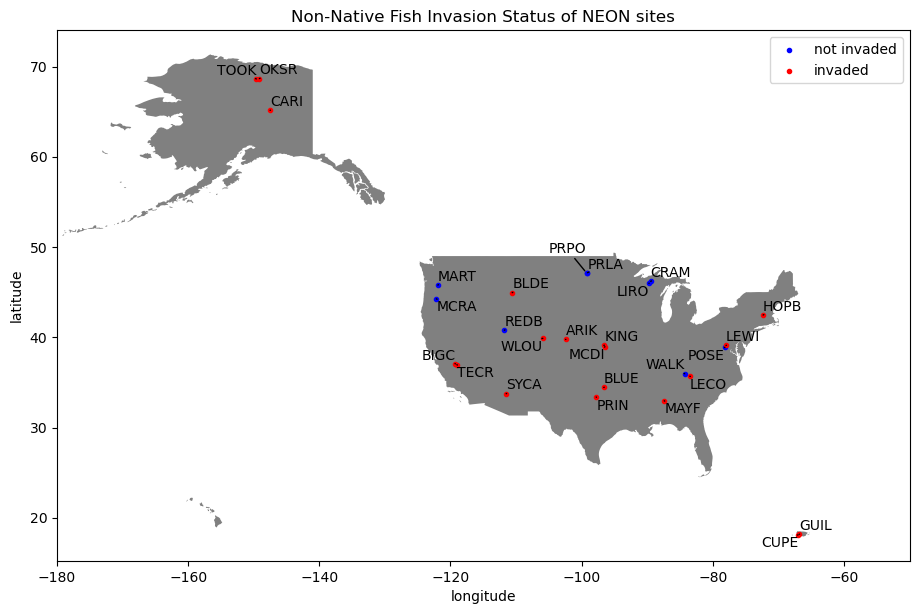

In [7]:
#create a plot of US map overlaid w/ invasion
fig, ax = plt.subplots(figsize = (11, 10))
US_map.plot(ax = ax, color = "grey")
plt.xlim(-180, -50)
plt.xlabel("longitude", fontsize = 10)
plt.ylabel("latitude", fontsize = 10)
plt.title("Non-Native Fish Invasion Status of NEON sites")
geo_df[geo_df['rel_invasive_richness'] == float(0)].plot(ax=ax, markersize = 9, color = "blue", marker = "o", label = "not invaded")
#invasion == 0 is for sites that are not invaded
geo_df[geo_df['rel_invasive_richness'] > float(0)].plot(ax=ax, markersize = 9, color = "red", marker = "o", label = "invaded")
plt.legend(prop={'size' : 10})
#invasion > 0 is sites that are invaded 

#add text for invasion sites
texts = []
for x,y,label in zip(geo_df["field_longitude"], geo_df["field_latitude"], geo_df['siteID']):
    texts.append(plt.text(x,y,label))
##scatters text points for easier readability
adjust_text(texts, only_move={'points':'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='black', lw=1))

#save figure 
plt.savefig("D:/Final_Project_Data/invaded_notinvadedMAP.jpg", dpi = 500)

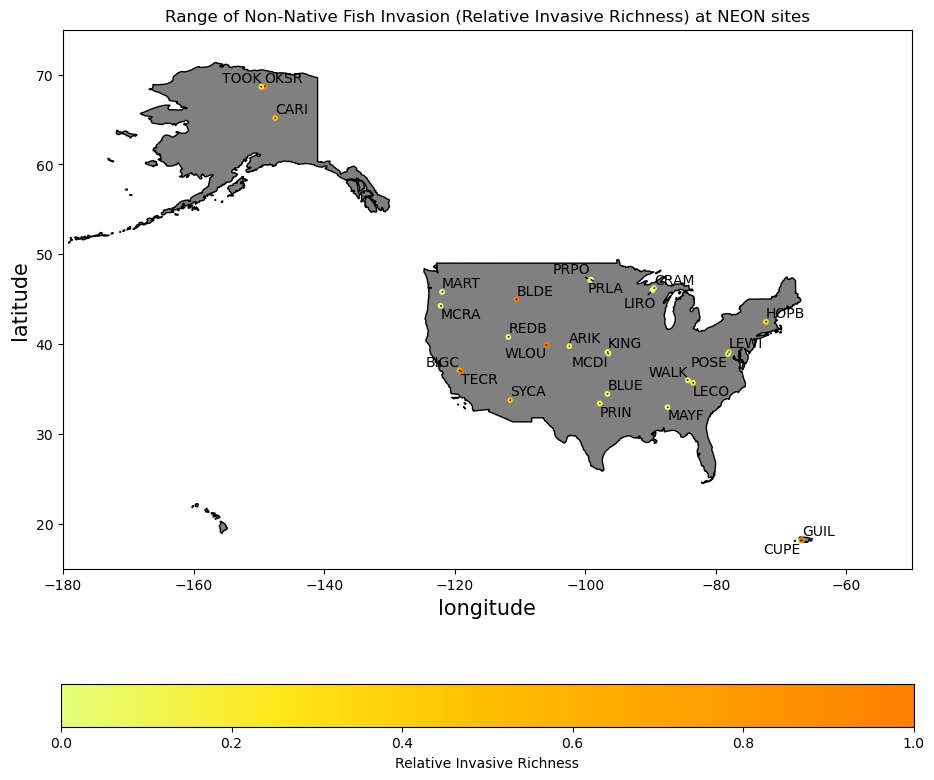

In [8]:
##choropleth maps RELATIVE INVASIVE RICHNESS
#create a map with invasion metrics overlaid
#color is a spectrum from least to most invaded
fig, ax = plt.subplots(figsize = (11,10))
US_map.plot(ax = ax, color = "grey", edgecolor = "black", legend = True)
plt.xlim(-180, -50)
plt.ylim(15, 75)
plt.xlabel("longitude", fontsize = 15)
plt.ylabel("latitude", fontsize = 15)
plt.title("Range of Non-Native Fish Invasion (Relative Invasive Richness) at NEON sites")
#add invasion sites on
geo_df.plot(column = 'rel_invasive_richness', ax = ax, legend = True, legend_kwds = {'label': "Relative Invasive Richness", 'orientation': "horizontal"}, markersize = 10, cmap = "Wistia", marker = 'o')
#add text invasion sites
texts = []
for x,y,label in zip(df["field_longitude"], df["field_latitude"], geo_df['siteID']):
    texts.append(plt.text(x,y,label))
##scatters points for easier readability
adjust_text(texts, only_move={'points':'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='black', lw=1))

#save figure
plt.savefig("D:/Final_Project_Data/invasion_spectrum_RIR.jpg", dpi = 500)

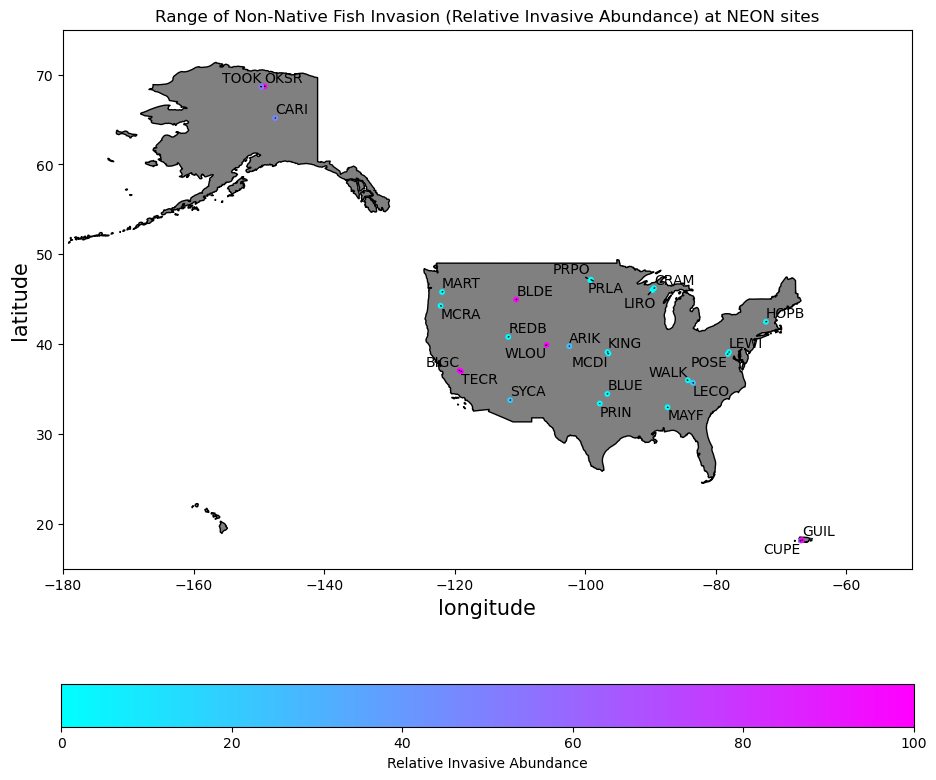

In [9]:
##choropleth maps RELATIVE INVASIVE ABUNDANCE
#create a map with invasion metrics overlaid
#color is a spectrum from least to most invaded
fig, ax = plt.subplots(figsize = (11,10))
US_map.plot(ax = ax, color = "grey", edgecolor = "black", legend = True)
plt.xlim(-180, -50)
plt.ylim(15, 75)
plt.xlabel("longitude", fontsize = 15)
plt.ylabel("latitude", fontsize = 15)
plt.title("Range of Non-Native Fish Invasion (Relative Invasive Abundance) at NEON sites")
#add invasion sites on
geo_df.plot(column = 'rel_inv_abund', ax = ax, legend = True, legend_kwds = {'label': "Relative Invasive Abundance", 'orientation': "horizontal"}, markersize = 10, cmap = "cool", marker = 'o')
#add text invasion sites
texts = []
for x,y,label in zip(df["field_longitude"], df["field_latitude"], geo_df['siteID']):
   # ax.annotate(label, 
                #xy = (x,y), xytext=(3, 3), textcoords="offset points")
    texts.append(plt.text(x,y,label))
##scatters points for easier readability
adjust_text(texts, only_move={'points':'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='black', lw=1))

#save figure
plt.savefig("D:/Final_Project_Data/invasion_spectrum_RIA.jpg", dpi = 500)

In [ ]:
##Nitrate Analysis

In [13]:
#import packages
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

In [14]:
#read in and process nitrate data
nitrate = pd.read_csv("nitrate_averages.csv")
nitrate.sort_values('year',ascending=False)
nitrate.head
nitrate_1 = nitrate[['siteID', 'siteMean']]
nitrate_1.head
nitrate_2 = nitrate_1.drop_duplicates()

In [15]:
nitrate_3 = nitrate_2.dropna() ##this drops one NA (LEWI)

In [16]:
#read in invasion data
invasion = pd.read_csv("full_response.csv")
invasion = invasion[["siteID", "rel_invasive_richness", "rel_inv_abund"]]
#combine nitrate and invasion data
combo = invasion.merge(nitrate_3, how = 'inner')
combo_1 = combo[["siteID", "siteMean", "rel_inv_abund", "rel_invasive_richness"]]
combo_1 = combo_1.loc[combo_1['rel_inv_abund'] > 0] #makes sites that are only invaded
combo_1 = combo_1.loc[combo_1['rel_invasive_richness'] > 0] #makes sites that are only invaded
combo_1.drop_duplicates() #condenses

,siteID,siteMean,rel_inv_abund,rel_invasive_richness
0,ARIK,6.893537,24.205225,0.100000
1,BIGC,2.606502,98.732171,0.500000
2,BLDE,6.889641,100.000000,1.000000
3,BLUE,32.130666,0.854701,0.038462
4,CARI,28.555919,46.808511,0.500000
6,CUPE,26.840689,53.555878,0.166667
7,GUIL,22.896214,100.000000,1.000000
8,HOPB,5.105799,2.135404,0.300000
9,KING,10.358878,2.255359,0.066667
10,LECO,16.014792,20.128676,0.250000


In [17]:
#compute spearman's correlation coefficient for nitrate vs relative invasive abundance
RIA_rho, RIA_p = spearmanr(combo_1['siteMean'], combo_1['rel_inv_abund'])
print(RIA_rho)
print(RIA_p)

-0.23463215172055052
0.34867146271380023


In [18]:
#compute spearman's correlation coefficient for nitrate vs relative invasive richness
RIR_rho, RIR_p = spearmanr(combo_1['siteMean'], combo_1['rel_invasive_richness'])
print(RIR_rho)
print(RIR_p)

-0.2831988582390269
0.2548031603508398


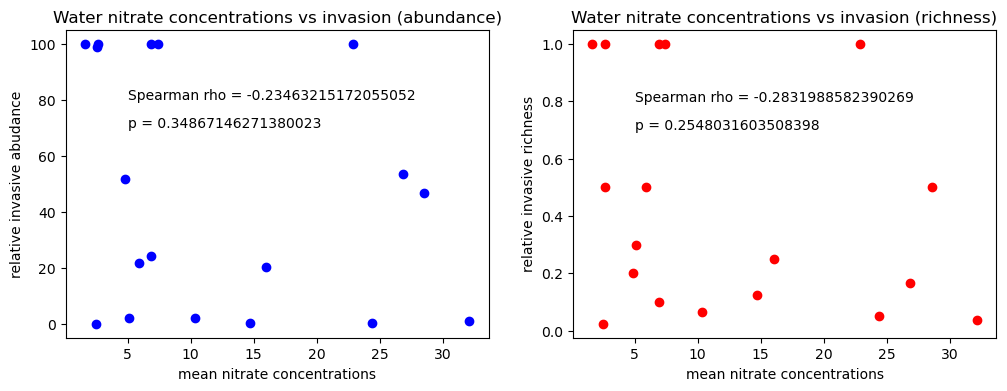

In [19]:
#create two plots side by side with nitrate means vs invasion with Spearman's corr written on top
fig, axes = plt.subplots(figsize = (12,4), ncols = 2)
ax0, ax1 = axes

ax0.set_title("Water nitrate concentrations vs invasion (abundance)", fontsize = 12)
ax1.set_title("Water nitrate concentrations vs invasion (richness)", fontsize = 12)
ax0.scatter(combo_1['siteMean'], combo_1['rel_inv_abund'], color = "blue")
ax0.set_xlabel("mean nitrate concentrations")
ax0.set_ylabel("relative invasive abudance")
ax1.scatter(combo_1['siteMean'], combo_1['rel_invasive_richness'], color = "red")
ax1.set_xlabel("mean nitrate concentrations")
ax1.set_ylabel("relative invasive richness")
ax0.annotate("Spearman rho = " + str(RIA_rho), xy = (5,80), xytext = (5,80))
ax0.annotate("p = " + str(RIA_p), xy = (5,70), xytext = (5,70))
ax1.annotate("Spearman rho = " + str(RIR_rho), xy = (5,0.8), xytext = (5,0.8))
ax1.annotate("p = " + str(RIR_p), xy = (5,0.7), xytext = (5,0.7))

#save figure 
plt.savefig("D:/Final_Project_Data/nitrate.jpg", dpi = 500)

In [ ]:
###for loop to create length plots

In [20]:
#import necessary packages
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

In [21]:
#read in observation data of length at each site
big = pd.read_csv("actinopterygii_fsh_perFish_sizeOutlierRemoved_anguillaRostrataRemoved_07-26-2022.csv", 
                  usecols=['siteTax','siteID', 'scientificName', 'fishTotalLength', 'fishWeight', 'nativeStatusCode'])
#reclassify STATE, FEDERAL, and F native status as NATIVE (invasive classification nuance)
big[['nativeStatusCode']] = big [['nativeStatusCode']].replace(to_replace = "FEDERAL", value = "N")
big[['nativeStatusCode']] = big [['nativeStatusCode']].replace(to_replace = "STATE", value = "N")
big[['nativeStatusCode']] = big [['nativeStatusCode']].replace(to_replace = "F", value = "N")
#convert mm length to cm
big['fishTotalLength_cm'] = (big['fishTotalLength'] / int(10))
#create a final df w/ taxon, siteID, observed lengths, and invasion status
big_2 = big[['siteTax', 'siteID', 'scientificName', 'fishTotalLength_cm', 'nativeStatusCode']]

In [23]:
#Read in fish Traits database w/ max total length reported for each species, pandas to sort through
fishbase = pd.read_csv("Narrowed_Augmented_Traits.csv", 
                      usecols = ['GENUS', 'SPECIES', 'MAXTL'])
fishbase["scientificName"] = fishbase["GENUS"] + " " + fishbase["SPECIES"]
fishbase_2 = fishbase[["MAXTL", "scientificName"]]

In [24]:
#combine observed traits and expected max by scientific Name
merge_length = pd.merge(big_2, fishbase_2, on = "scientificName")
merge_length.head()

,siteTax,siteID,scientificName,fishTotalLength_cm,nativeStatusCode,MAXTL
0,HOPB RHIATR,HOPB,Rhinichthys atratulus,3.1,N,10.0
1,HOPB RHIATR,HOPB,Rhinichthys atratulus,7.7,N,10.0
2,HOPB RHIATR,HOPB,Rhinichthys atratulus,3.4,N,10.0
3,HOPB RHIATR,HOPB,Rhinichthys atratulus,6.8,N,10.0
4,HOPB RHIATR,HOPB,Rhinichthys atratulus,7.7,N,10.0


In [25]:
#getting ready to for loop through sites and create plots
siteID = merge_length["siteID"].unique() #array of unique siteID to use in for loop 
print(siteID[0])

HOPB


In [26]:
#create and save plots for each site (28)
for site in siteID:
    #set up temp df
    temp_site = merge_length[merge_length["siteID"] == site] 
    
    #define a plot
    fig, ax1 = plt.subplots()
    
    #query temp df to get min and max and use that to set matching y-axes labels
    obs_min = temp_site['fishTotalLength_cm'].min()
    obs_max = temp_site['fishTotalLength_cm'].max()
    fb_min = temp_site['MAXTL'].min()
    fb_max = temp_site['MAXTL'].max()
    minimalist = min(obs_min, fb_min)-5
    maximalist = max(obs_max, fb_max)+5
    
    #rotate x-axis labels
    plt.xticks(rotation = 90)
    
    #set observed length data
    ax1.set_xlabel('Species')
    ax1.set_ylabel('Observed lengths (cm)', color = "blue")
    ax1.scatter(temp_site['scientificName'], temp_site['fishTotalLength_cm'], color = "blue")
    ax1.set_ylim(minimalist,maximalist)
    
    #twins second axis onto same plot (fishtraits data)
    ax2 = ax1.twinx()

    ax2.set_ylabel('Max Total Length (cm) (FishTraits)', color = "red")
    ax2.scatter(temp_site['scientificName'], temp_site['MAXTL'], color = "red")
    ax2.set_ylim(minimalist, maximalist)
    
    #use site name as graph title
    plt.title(site)
    #save out figure to folder
    plt.savefig("site_length_output_plot/" + site + ".jpg", dpi = 200, bbox_inches = 'tight')
    
    #clear plot so that it doesn't bog down jupyter lab with lots of images
    #plt.clf()
    #ensures axes titles aren't cut off in the final saved plot
    plt.tight_layout()

C:\Users\brigi\AppData\Local\Temp\ipykernel_12532\1363597966.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>